## Reading, Drawing, and Analyzing a Molecule

In [1]:
# import RDKit
from rdkit import Chem
from rdkit.Chem import Draw

from rdkit.Chem import RDKFingerprint
from rdkit.Chem import rdMolDescriptors

from mol2vec.features import mol2alt_sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

import networkx as nx

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# 将一个SMILES字符串转为分子结构
caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'

mol = Chem.MolFromSmiles(caffeine_smiles)

# 绘制分子
Draw.MolToFile(mol, './images/caffine.png', size=(300,300))

# 绘制出每个原子的属性
for i, atom in enumerate(mol.GetAtoms()):
    atom.SetProp('molAtomMapNumber', str(atom.GetIdx()))

Draw.MolToFile(mol, './images/caffine_with_prop.png', size=(300,300))

在RDKit中，GetBeginAtomIdx() 和 GetEndAtomIdx() 这两个函数通常与分子中的化学键（bonds）相关联，用于获取一个化学键所连接的两个原子在分子中的索引位置。

1. GetBeginAtomIdx(): 此函数返回调用它的化学键所连接的第一个原子的索引。在RDKit中，每个原子在分子中都有一个唯一的索引，从0开始。

2. GetEndAtomIdx(): 此函数返回调用它的化学键所连接的第二个原子的索引。

这两个函数对于理解和操作分子结构中的化学键非常有用。例如，你可能想要知道一个化学键连接了哪两个原子，或者在遍历分子中的所有化学键时，获取连接原子的详细信息。

In [3]:
# 展示分子的原子和化学键
print('print the atoms:')
for atom in mol.GetAtoms():
    print(atom.GetIdx(),
          atom.GetAtomicNum(),  # 返回原子序数
          atom.GetIsAromatic(),
          atom.GetSymbol())

print('print the bonds:')
for bond in mol.GetBonds():
    print(bond.GetBeginAtomIdx(),
          bond.GetEndAtomIdx(),
          bond.GetBondType())

print the atoms:
0 6 False C
1 7 True N
2 6 True C
3 7 True N
4 6 True C
5 6 True C
6 6 True C
7 8 False O
8 7 True N
9 6 True C
10 8 False O
11 7 True N
12 6 False C
13 6 False C
print the bonds:
0 1 SINGLE
1 2 AROMATIC
2 3 AROMATIC
3 4 AROMATIC
4 5 AROMATIC
5 6 AROMATIC
6 7 DOUBLE
6 8 AROMATIC
8 9 AROMATIC
9 10 DOUBLE
9 11 AROMATIC
11 12 SINGLE
8 13 SINGLE
5 1 AROMATIC
11 4 AROMATIC


## Generating Molecular Fingerprint from a SMILES String

In [4]:
# 检索 RDK Fingerprint
fingerprint_rdk = RDKFingerprint(mol)
print(f"RDK Fingerprint: {fingerprint_rdk}")

fingerprint_rdk_np = np.array(fingerprint_rdk)
print(f"RDK Fingerprint in numpy: {fingerprint_rdk_np} \
       Shape: {fingerprint_rdk_np.shape}")

# 检索 Morgan Fingerprint
fingerprint_morgan = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2)
print(f"Morgan Fingerprint: {fingerprint_morgan}")

fingerprint_morgan_np = np.array(fingerprint_morgan)
print(f"Morgan Fingerprint: {fingerprint_morgan_np} \
       Shape: {fingerprint_morgan_np.shape}"
)

RDK Fingerprint: <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x0000024BE8253900>
RDK Fingerprint in numpy: [1 1 0 ... 0 0 1]        Shape: (2048,)
Morgan Fingerprint: <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x0000024BE8253B30>
Morgan Fingerprint: [0 0 0 ... 0 0 0]        Shape: (2048,)


[20:11:25] DEPRECATION WARNING: please use MorganGenerator


## Generating One-Hot Encoding from a SMILES string  
在SMILES字符串的字符级别生成one-hot编码

In [5]:
# define SMILES characters ----------------------------------------------------
SMILES_CHARS = [' ',
                '#', '%', '(', ')', '+', '-', '.', '/',
                '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                '=', '@',
                'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
                'R', 'S', 'T', 'V', 'X', 'Z',
                '[', '\\', ']',
                'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
                't', 'u']

# define encoder and decoder --------------------------------------------------
smi2index = dict( (c,i) for i,c in enumerate( SMILES_CHARS ) )
index2smi = dict( (i,c) for i,c in enumerate( SMILES_CHARS ) )

def simles_encoder(simles, maxlen=120):
    X = np.zeros((maxlen, len(SMILES_CHARS)))
    for i, char in enumerate(simles):
        X[i, smi2index[char]] = 1
    return X

def simles_decoder(X):
    smi = ''
    X = X.argmax(axis=-1)
    for i in X:
        smi += index2smi[i]
    return smi

caffeine_encoding = simles_encoder(caffeine_smiles)
print(f"caffeine_encoding.shape: {caffeine_encoding.shape} \nCaffeine encoding: \n{caffeine_encoding}")

caffeine_encoding.shape: (120, 56) 
Caffeine encoding: 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Generating Word Embedding from a SMILES String  
将词嵌入的方法应用于分子的子结构

In [2]:
# import rdkit/mol2vec/word2vec
from rdkit import Chem
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

import numpy as np
import pandas as pd

In [3]:
smi1 = "C1C(NC2=C(N1)NC(=NC2=O)N)CN(C=O)C3=CC=C(C=C3)C(=O)NC(CCC(=O)O)C(=O)O"
smi2 = "C(CCl)Cl"

mol1 = Chem.MolFromSmiles(smi1)
mol2 = Chem.MolFromSmiles(smi2)

In [4]:
# create sentence from mol
sentence = MolSentence(mol2alt_sentence(mol1, radius=1))

[11:24:11] DEPRECATION WARNING: please use MorganGenerator


In [ ]:
# load the word2vec model
w2v_model = word2vec.Word2Vec.load("model_300dim.pkl")

## Generating Molecular Representation in Graph  
将 RDKit 中的分子转换为 NetworkX 中的图形

In [6]:
# 将 rdkit 转为 networkx
def mol2nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), 
                   atomic_num=atom.GetAtomicNum(),
                   is_arotic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())
        
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(), 
                   bond.GetEndAtomIdx(), 
                   bond_type=bond.GetBondType())
        
    return G

color_map = {
    'C': 'cyan',
    'O': 'orange',
    'N': 'magenta'
}

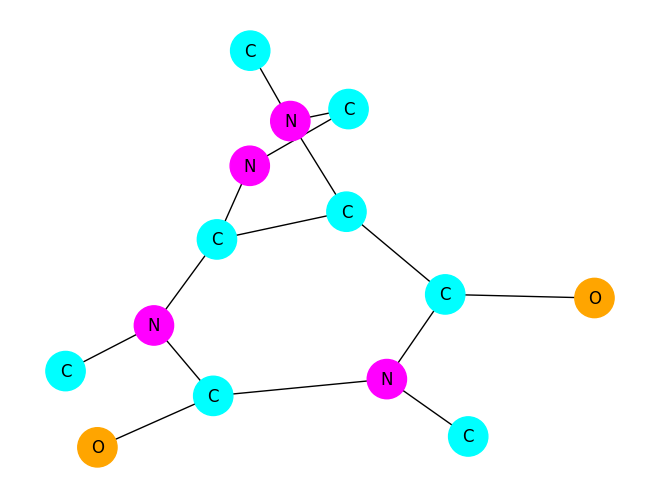

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [8]:
caffeine_nx_graph = mol2nx(mol)

caffeine_atom = nx.get_node_attributes(caffeine_nx_graph, 'atom_symbol')

caffeine_colors = []
for idx in caffeine_nx_graph.nodes():
    if (caffeine_nx_graph.nodes[idx]['atom_symbol'] in color_map):
        caffeine_colors.append(color_map[caffeine_nx_graph.nodes[idx]['atom_symbol']])
    else:
        caffeine_colors.append('gray')

nx.draw(caffeine_nx_graph,
        labels=caffeine_atom,
        with_labels=True,
        node_color=caffeine_colors,
        node_size=800)
plt.show()

# 输出邻接矩阵
adj_matrix = nx.to_numpy_array(caffeine_nx_graph)
print(adj_matrix)

一般来说，图嵌入由三个主题组成：节点级嵌入（将图中的节点编码为向量）、边缘级嵌入（将图中的边编码为向量）和图级嵌入（将整个图编码为向量）。在这篇文章中，我们将术语图嵌入视为图级嵌入，它为分子找到一个向量，该向量可以用作下游模型的输入。  

将 RDKit 中的分子转换为 NetworkX 中的图形，并通过 KarateClub 下的 Graph2Vec 生成其图形嵌入的代码。Graph2Vec 是一种图嵌入算法，KarateClub 是一个为图数据提供无监督机器学习模型的软件包

In [1]:
# import rdkit/networkx/graph2vec
from rdkit import Chem
import networkx as nx
from karateclub import Graph2Vec

In [2]:
def smiles2nx(smi):
    mol = Chem.MolFromSmiles(smi)
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(), 
                   atomic_num=atom.GetAtomicNum(),
                   is_arotic=atom.GetIsAromatic(),
                   atom_symbol=atom.GetSymbol())

    for bond in mol.GetBonds(): 
        G.add_edge(bond.GetBeginAtomIdx(), 
                   bond.GetEndAtomIdx(), 
                   bond_type=bond.GetBondType())

    return G

In [10]:
caffeine_nx_graph = smiles2nx(caffeine_smiles)
# create graph2vec model
g2v_model = Graph2Vec(dimensions=128, workers=4)
# fit model
g2v_model.fit([caffeine_nx_graph])
# get embedding
embedding = g2v_model.get_embedding()
print(embedding)

[[ 6.24450669e-03  7.31988903e-03  6.24006055e-03 -5.99076785e-03
  -6.63260417e-03 -3.53924930e-03 -3.34743224e-03  3.59894964e-03
  -5.20930393e-03 -6.60916697e-03 -3.61388014e-03  7.59077165e-03
  -3.64172598e-03  1.17201218e-03  6.87342696e-03  3.38666956e-03
  -7.59500253e-04  7.29397126e-03 -4.64901933e-03  4.32103174e-03
   3.15239793e-03 -2.75088497e-03 -7.29451829e-04 -6.88411715e-03
   4.12077679e-05 -2.07462232e-03  7.74890510e-03 -3.68959573e-03
  -5.28225536e-03  8.78037827e-04 -6.11178298e-03 -6.22744439e-03
  -5.12534752e-03 -4.76617087e-03 -3.39930691e-03 -1.53508061e-03
  -1.94117893e-03  4.50850325e-03  5.34264510e-03 -3.54541768e-03
  -4.95912228e-03  6.09943178e-04 -3.52512882e-03  2.01975454e-05
   5.61044412e-03  3.03675514e-03 -4.22990602e-03 -1.00301707e-03
   1.43025871e-04 -6.31882204e-03  7.70978769e-03  6.50099386e-03
  -2.33168339e-05  4.57346812e-03  3.52309807e-03  6.77101407e-03
   2.85385968e-03 -7.25552626e-03 -1.91660586e-03  2.80478969e-03
  -4.47777

In [12]:
embedding.shape

(1, 128)

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import matplotlib.pyplot as plt

# 1. 将 SMILES 转换为分子对象
smiles = 'CCO'  # 乙醇的 SMILES
mol = Chem.MolFromSmiles(smiles)

# 2. 生成 2D 坐标
AllChem.Compute2DCoords(mol)

# 3. 绘制并显示分子图像
img = Draw.MolToImage(mol)  # 返回分子图的PIL图像对象
img.show()